## Case Fraude

Essa base de dados apresenta dados através dos quais será possível realizar uma análise e criação de modelo para detecção de fraudes em cartões de crédito.

Sabe-se que fraudes em cartões de crédito podem gerar grandes prejuízos, além de frutração a clientes. Sendo assim, possuir um modelo que tenha uma taxa de erro baixa é importante para evitar prejuízos e o churn.

Dados

score_1 a score_10: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre

País: pais de compra

Produto: produto que está sendo comprado no e-commerce

Categoria_produto: categoria a qual esse produto se encaixa

Entrega_doc_1 a entrega_doc_3: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou

Score_fraude_modelo: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude

Fraude: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

In [1]:
# importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import pkg_resources
import sys
from tabulate import tabulate

In [2]:
# verificando as versões das bibliotecas utilizadas

def get_library_versions():
    libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'plotly', 'missingno', 'scipy', 'xgboost', 'lightgbm']

    versions = []
    for lib in libraries:
        try:
            version = __import__(lib).__version__
            versions.append([lib, version])
        except ImportError:
            versions.append([lib, 'Não encontrado'])

    # Adiciona a versão do Python
    versions.append(['python', f'{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}'])

    return versions

if __name__ == "__main__":
    versions = get_library_versions()

    # Imprime as versões como uma tabela
    headers = ['Biblioteca', 'Versão']
    print(tabulate(versions, headers, tablefmt='fancy_grid'))

╒══════════════╤══════════╕
│ Biblioteca   │ Versão   │
╞══════════════╪══════════╡
│ pandas       │ 1.5.3    │
├──────────────┼──────────┤
│ numpy        │ 1.24.3   │
├──────────────┼──────────┤
│ matplotlib   │ 3.7.1    │
├──────────────┼──────────┤
│ seaborn      │ 0.12.2   │
├──────────────┼──────────┤
│ plotly       │ 5.9.0    │
├──────────────┼──────────┤
│ missingno    │ 0.5.2    │
├──────────────┼──────────┤
│ scipy        │ 1.10.1   │
├──────────────┼──────────┤
│ xgboost      │ 2.0.2    │
├──────────────┼──────────┤
│ lightgbm     │ 4.1.0    │
├──────────────┼──────────┤
│ python       │ 3.11.4   │
╘══════════════╧══════════╛


In [3]:
base = pd.read_excel(r'c:/Users/carol/Downloads/dados.xlsx')

In [4]:
base.head(3)

score_1  score_2    score_3  score_4   score_5  score_6 pais  score_7  \
0        4   0.7685   94436.24     20.0  0.444828      1.0   BR        5   
1        4   0.7550    9258.50      1.0  0.000000     33.0   BR        0   
2        4   0.7455  242549.09      3.0  0.000000     19.0   AR       23   

                                             produto categoria_produto  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...       cat_8d714cd   
1  Avental Descartavel Manga Longa  - 50 Un. Tnt ...       cat_64b574b   
2  Bicicleta Mountain Fire Bird Rodado 29 Alumini...       cat_e9110c5   

    score_8  score_9  score_10  entrega_doc_1 entrega_doc_2 entrega_doc_3  \
0  0.883598    240.0     102.0              1           NaN             N   
1  0.376019   4008.0       0.0              1             Y             N   
2  0.516368   1779.0      77.0              1           NaN             N   

          data_compra  valor_compra  score_fraude_modelo  fraude  
0 2020-03-27 11:51:16          5.64                   66       0  
1 2020-04-15 19:58:08        124.71                   72       0  
2 2020-03-25 18:13:38        339.32                   95       0

In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   score_1              150000 non-null  int64         
 1   score_2              137016 non-null  float64       
 2   score_3              137016 non-null  float64       
 3   score_4              149635 non-null  float64       
 4   score_5              150000 non-null  float64       
 5   score_6              149989 non-null  float64       
 6   pais                 149806 non-null  object        
 7   score_7              150000 non-null  int64         
 8   produto              150000 non-null  object        
 9   categoria_produto    150000 non-null  object        
 10  score_8              150000 non-null  float64       
 11  score_9              149989 non-null  float64       
 12  score_10             149635 non-null  float64       
 13  entrega_doc_1 

In [6]:
base.describe()

score_1        score_2       score_3        score_4  \
count  150000.000000  137016.000000  1.370160e+05  149635.000000   
mean        3.705407       0.728115  2.604451e+05      21.677669   
std         0.753206       0.132943  8.464361e+05      20.062146   
min         1.000000       0.000000  1.600000e-01       0.000000   
25%         4.000000       0.678400  9.679915e+03       2.000000   
50%         4.000000       0.755500  4.371165e+04      14.000000   
75%         4.000000       0.806500  1.454436e+05      50.000000   
max         4.000000       1.000000  1.387874e+07      50.000000   

             score_5        score_6        score_7        score_8  \
count  150000.000000  149989.000000  150000.000000  150000.000000   
mean        0.220641      51.169352      14.193513       0.497532   
std         2.434995     709.472904      14.161216       0.288348   
min         0.000000      -5.000000       0.000000       0.000004   
25%         0.000000       1.000000       3.000000       0.246819   
50%         0.104875       8.000000       9.000000       0.495990   
75%         0.282938      33.000000      21.000000       0.746508   
max       833.333333  145274.000000      58.000000       0.999995   

             score_9       score_10  entrega_doc_1   valor_compra  \
count  149989.000000  149635.000000  150000.000000  150000.000000   
mean     2305.409403     299.969579       0.902353      43.523134   
std      1712.379601     321.075806       0.296837      91.557888   
min         0.000000       0.000000       0.000000       0.020000   
25%       910.000000      42.000000       1.000000       9.380000   
50%      1937.000000     193.000000       1.000000      20.610000   
75%      3445.000000     459.000000       1.000000      40.692500   
max      7544.000000    2225.000000       1.000000    3696.350000   

       score_fraude_modelo         fraude  
count        150000.000000  150000.000000  
mean             48.066240       0.050000  
std              28.995122       0.217946  
min               0.000000       0.000000  
25%              23.000000       0.000000  
50%              48.000000       0.000000  
75%              73.000000       0.000000  
max             100.000000       1.000000

In [7]:
base.shape

(150000, 20)

In [8]:
base.duplicated().sum()

0

In [9]:
#percentual de itens nulos
(base.isnull().sum()/base.shape[0] * 100).round(2)

score_1                 0.00
score_2                 8.66
score_3                 8.66
score_4                 0.24
score_5                 0.00
score_6                 0.01
pais                    0.13
score_7                 0.00
produto                 0.00
categoria_produto       0.00
score_8                 0.00
score_9                 0.01
score_10                0.24
entrega_doc_1           0.00
entrega_doc_2          72.57
entrega_doc_3           0.00
data_compra             0.00
valor_compra            0.00
score_fraude_modelo     0.00
fraude                  0.00
dtype: float64

Podemos visualizar uma grande quantidade de itens faltantes na coluna "entrega_doc_2"

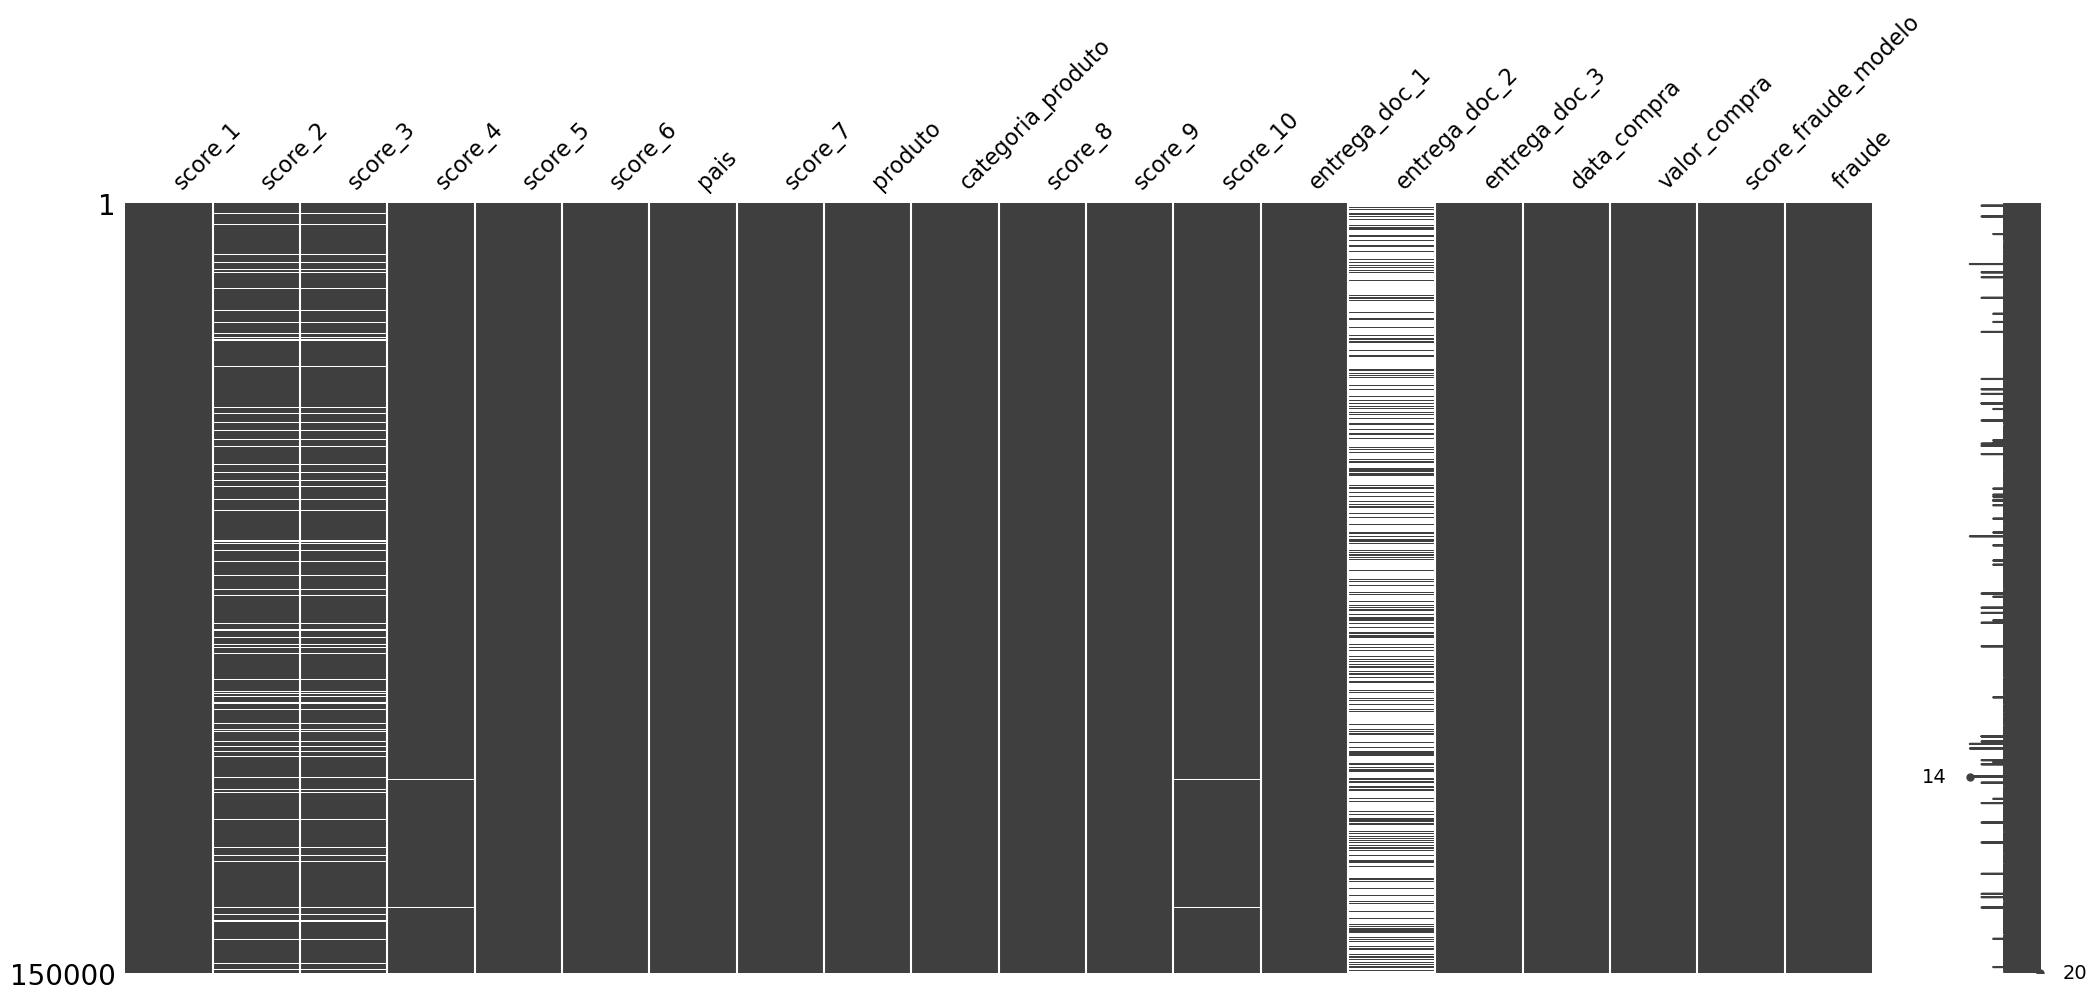

In [10]:
#forma mais visual de mostrar os dados 'missing'
msno.matrix(base);


A partir desse gráfico conseguimos visualizar de maneira mais clara a quantidade de dados faltantes em cada coluna, sobressaindo a coluna "entrega_doc_2", sendo que os valores nulos podem representar a não entrega de documentos, o que pode estar relacionado a possíveis fraudadores.

In [11]:
base.pais.value_counts()

BR    111628
AR     31964
UY      2967
US      2273
SE       358
MX       236
RU        73
ES        69
CO        64
GB        43
FR        18
IT        14
PT        13
DE         9
CL         9
PE         5
EC         4
PY         4
AU         3
PA         3
CA         3
UA         3
BE         3
CN         3
CH         3
NZ         3
PR         2
NL         2
BO         2
CR         2
AE         2
LB         2
FI         1
TW         1
NO         1
EG         1
IL         1
PH         1
JP         1
GH         1
NI         1
DO         1
BS         1
TR         1
IN         1
GR         1
HN         1
KR         1
GE         1
AD         1
ZA         1
Name: pais, dtype: int64

In [12]:
(base.pais.value_counts()/base.shape[0]*100).round(2).head(17)

BR    74.42
AR    21.31
UY     1.98
US     1.52
SE     0.24
MX     0.16
RU     0.05
ES     0.05
CO     0.04
GB     0.03
FR     0.01
IT     0.01
PT     0.01
DE     0.01
CL     0.01
PE     0.00
EC     0.00
Name: pais, dtype: float64

In [13]:
#verificando o número de países na base
len(base.pais.unique())

52

In [14]:
#verificando fraudes em cada país
paises = ((base.pais.loc[base.fraude == 1].value_counts()/base.loc[base.fraude == 1].shape[0])*100).round(2)
paises


BR    82.16
AR    15.72
US     0.93
UY     0.39
SE     0.20
RU     0.08
ES     0.07
MX     0.04
FR     0.04
DE     0.04
EC     0.03
NL     0.03
KR     0.01
CO     0.01
NZ     0.01
FI     0.01
CL     0.01
PT     0.01
Name: pais, dtype: float64

In [15]:
fig = px.bar(x=paises.index, y=paises.values, labels={'x': 'Países', 'y': 'Porcentagem de Fraudes'},
             title='Porcentagem de Fraudes por País')

fig.update_xaxes(tickangle=45)

fig.show()

Dentre os 51 países do nosso dataset, os países com maior número de fraudes são o Brasil e a Argentina

In [16]:
base.produto.value_counts()

Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Bateria Zetta, Nova, Com Nota Fiscal, 12 Mês De Garantia         1
Dispenser Jabón Liquido / Alcohol En Gel X Unidad                1
Moletom Gola Redonda Shawn Mendes Top 98 Unissex Promoção        1
Placa Interface Adesivo Lavadora Brastemp Bwl11 Emicol Biv.      1
A Magia Divina Das Velas. O Livro Das Sete Chamas Sagradas       1
Name: produto, Length: 127804, dtype: int64

In [17]:
# número de produtos encontrado na base de dados
len(base.produto.unique())

127804

In [18]:
# número de categorias ncontradas na base de dados
base['categoria_produto'].value_counts().head(15)

cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
cat_3203c7c    1093
cat_be0af8e    1040
cat_0820fab     938
cat_8ef7164     909
cat_d5975ae     878
cat_f0ec611     775
cat_960e53d     755
cat_0eb83e7     748
cat_e600e6d     709
cat_ffe7351     684
Name: categoria_produto, dtype: int64

In [19]:
# verificação de fraude por categoria
# Contagem de itens por categoria
category_counts = base['categoria_produto'].value_counts().reset_index().rename(columns={"index": "categoria_produto", "categoria_produto": "counter"})

# Soma de fraudes por categoria
fraud_counts = base.groupby('categoria_produto')['fraude'].sum().reset_index()

# Fusão dos dataframes
category_fraud_info = pd.merge(category_counts, fraud_counts, on='categoria_produto', how='left')

# Criação da coluna de percentual acumulado de fraudes
category_fraud_info['percent_cumsum_fraude'] = category_fraud_info['fraude'].cumsum() / base['fraude'].sum() * 100

# Exibição das 1000 primeiras linhas
display(category_fraud_info.head(1000))



categoria_produto  counter  fraude  percent_cumsum_fraude
0         cat_43b9c10     2331     380               5.066667
1         cat_d69bed9     1799      54               5.786667
2         cat_604df77     1784      71               6.733333
3         cat_6c4cfdc     1449      74               7.720000
4         cat_4249bd8     1191      98               9.026667
..                ...      ...     ...                    ...
995       cat_e62cf2d       29       0              79.973333
996       cat_d7c8a47       29       2              80.000000
997       cat_1a13152       29       1              80.013333
998       cat_c766714       29       1              80.026667
999       cat_e189df3       29       3              80.066667

[1000 rows x 4 columns]

In [20]:
len(base['categoria_produto'].unique())

8324

In [21]:
doc1 = base.entrega_doc_1.value_counts()
doc1

1    135353
0     14647
Name: entrega_doc_1, dtype: int64

In [22]:
fig = px.bar(x=doc1.index, y=doc1.values, labels={'x': 'Documento 1', 'y': 'Número de Documentos'},
             title='Quantidade de Documentos entregue')


fig.show()

In [23]:
fig = px.pie(names=doc1.index, values=doc1.values, title='Distribuição de Entrega de Documento 2')

# Exibe o gráfico
fig.show()

A maioria dos users entregaram o doc 1

In [24]:
doc2 = base.entrega_doc_2.value_counts()
doc2

Y    24091
N    17052
Name: entrega_doc_2, dtype: int64

In [25]:
fig = px.bar(x=doc2.index, y=doc2.values, labels={'x': 'Documento 2', 'y': 'Número de Documentos'},
             title='Quantidade de Documentos entregue')


fig.show()

In [26]:
fig = px.pie(names=doc2.index, values=doc2.values, title='Distribuição de Entrega de Documento 2')

# Exibe o gráfico
fig.show()

In [27]:
doc3 = base.entrega_doc_3.value_counts()
doc3

Y    83129
N    66871
Name: entrega_doc_3, dtype: int64

In [28]:
fig = px.bar(x=doc3.index, y=doc3.values, labels={'x': 'Documento 3', 'y': 'Número de Documentos'},
             title='Quantidade de Documentos entregue')


fig.show()

In [29]:
fig = px.pie(names=doc3.index, values=doc3.values, title='Distribuição de Entrega de Documento 2')

# Exibe o gráfico
fig.show()

#### Verificando as fraudes

In [30]:
fraude = base.fraude.value_counts()
fraude

0    142500
1      7500
Name: fraude, dtype: int64

In [31]:
fig = px.pie(names=fraude.index, values=fraude.values, title='Distribuição das Fraudes')

# Exibe o gráfico
fig.show()

A partir desse gráfico podemos verificar que o número de fraudes é muito menor do que o número de não fraudes, o que indica um dataset desbalanceado

##### Histogramas das colunas Score

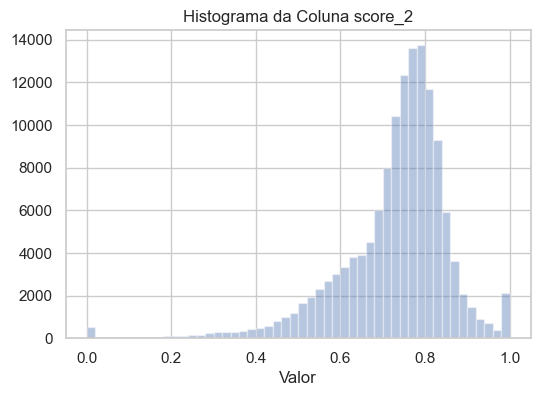

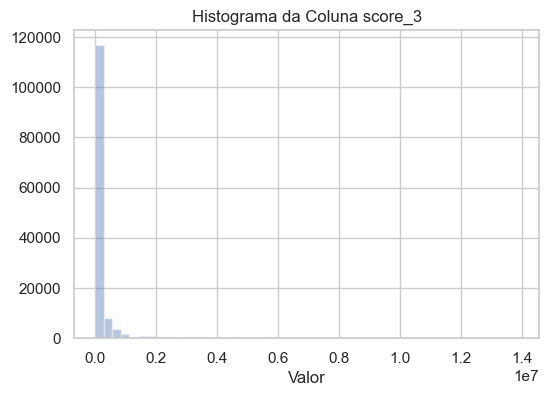

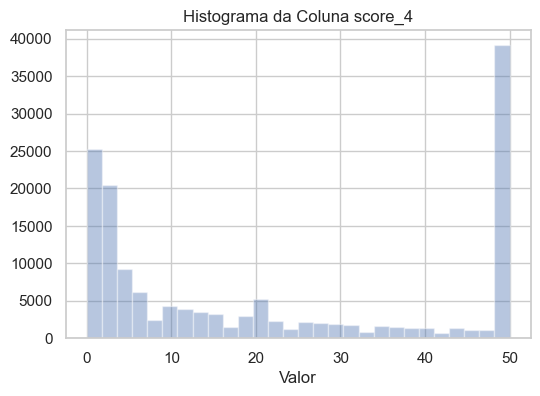

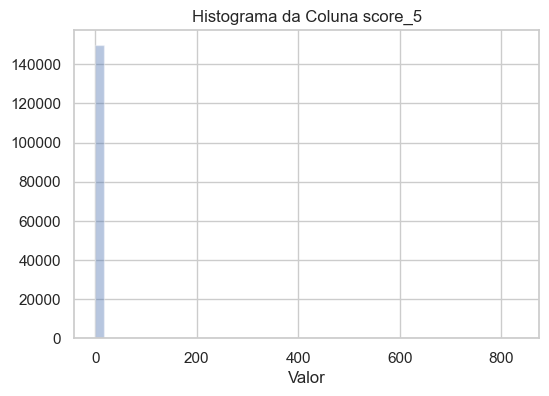

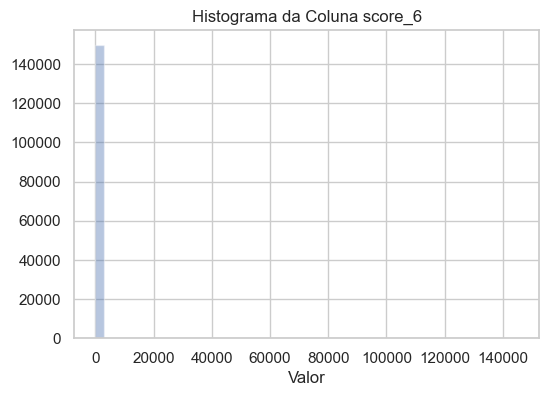

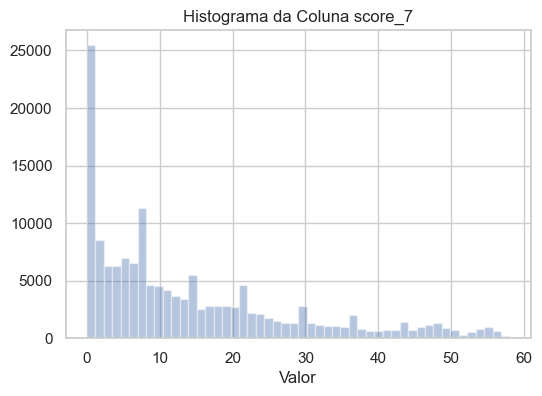

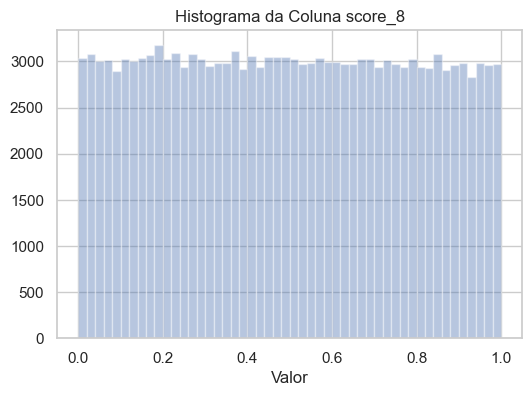

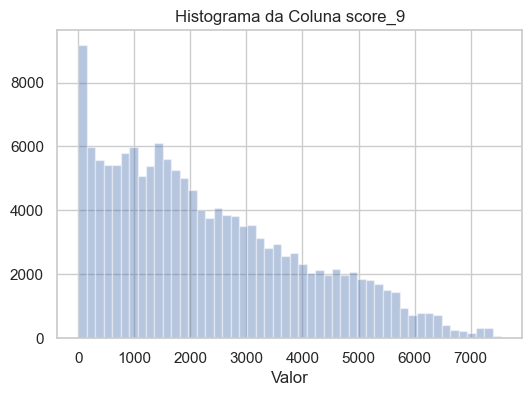

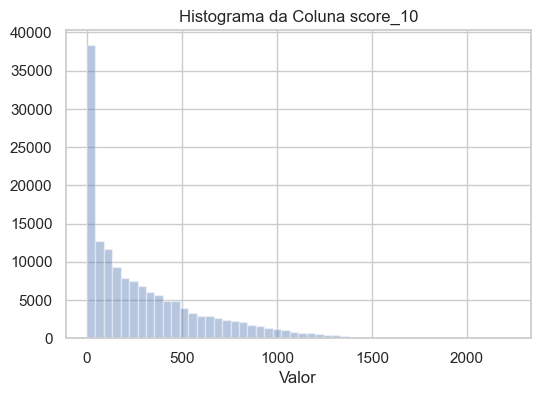

In [32]:
colunas_score = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

sns.set(style='whitegrid')

# criando um histograma pra cada coluna 'score'
for coluna in colunas_score:
    plt.figure(figsize=(6, 4))
    plt.title(f'Histograma da Coluna {coluna}')
    sns.distplot(base[coluna], kde=False)
    plt.xlabel('Valor')
    plt.show()

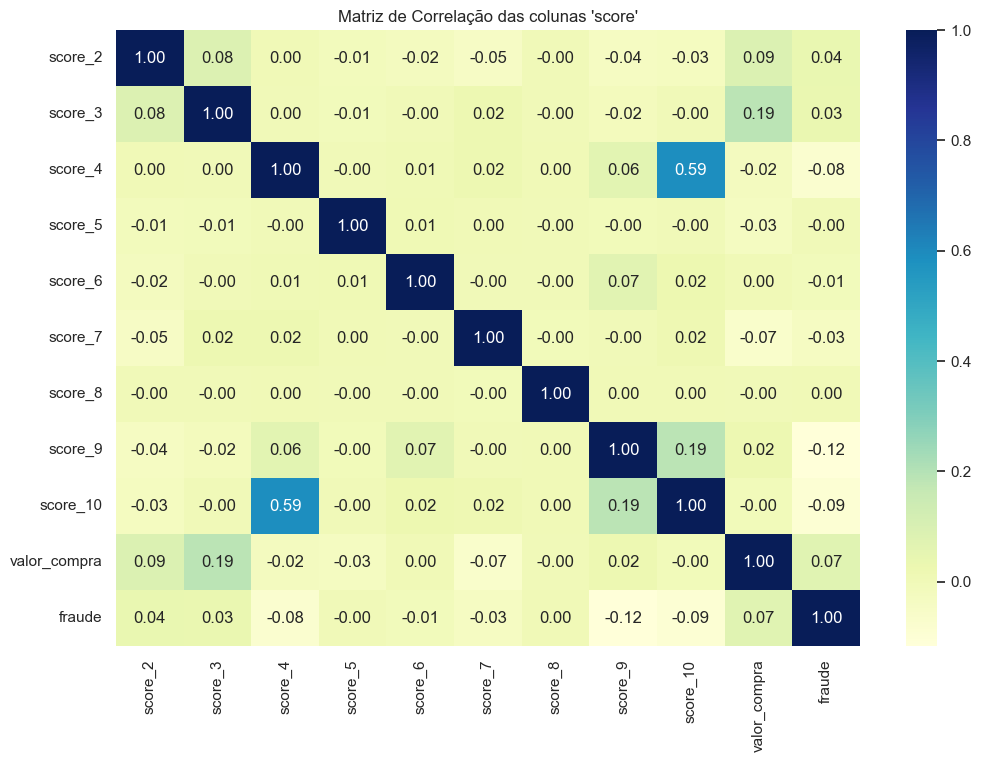

In [33]:
# verificando a correlação entre as colunas 'score'
corr = base[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra', 'fraude']].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, annot = True, cmap = "YlGnBu", fmt = ".2f" )
plt.title("Matriz de Correlação das colunas 'score'")
plt.show()

Correlação moderada entre as variáveis 'score_4' e 'score_10', de 0,59. Por não ser uma correlação forte, não deverá ser removida.

In [34]:
#verificando os valores de compra
base.valor_compra.describe()

count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: valor_compra, dtype: float64

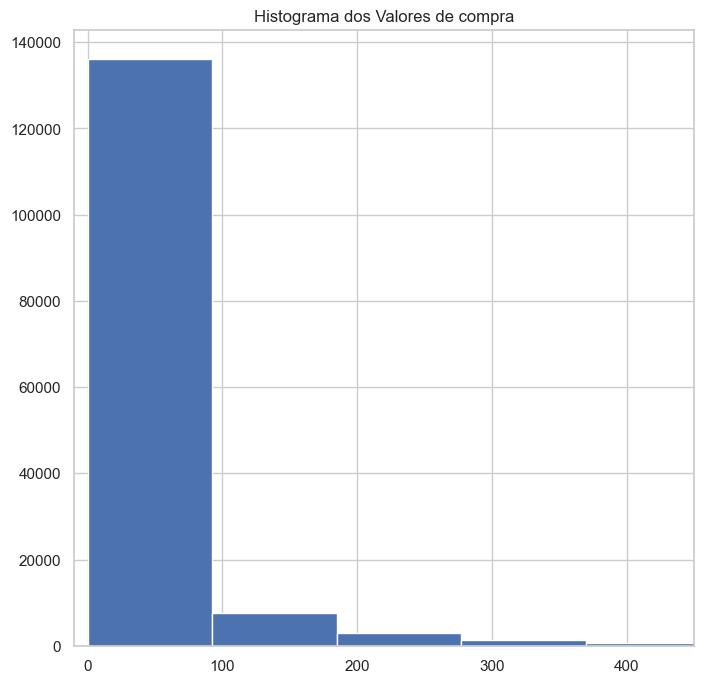

In [35]:
#histograma da coluna 'valor_compra'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Histograma dos Valores de compra')
ax.set_xlim(-10, 450)
base.valor_compra.hist(ax = ax, bins = 40)
fig.show();

In [36]:
base_pairplot = base[['score_3','entrega_doc_1','score_9','score_6','valor_compra', 'fraude']].copy()

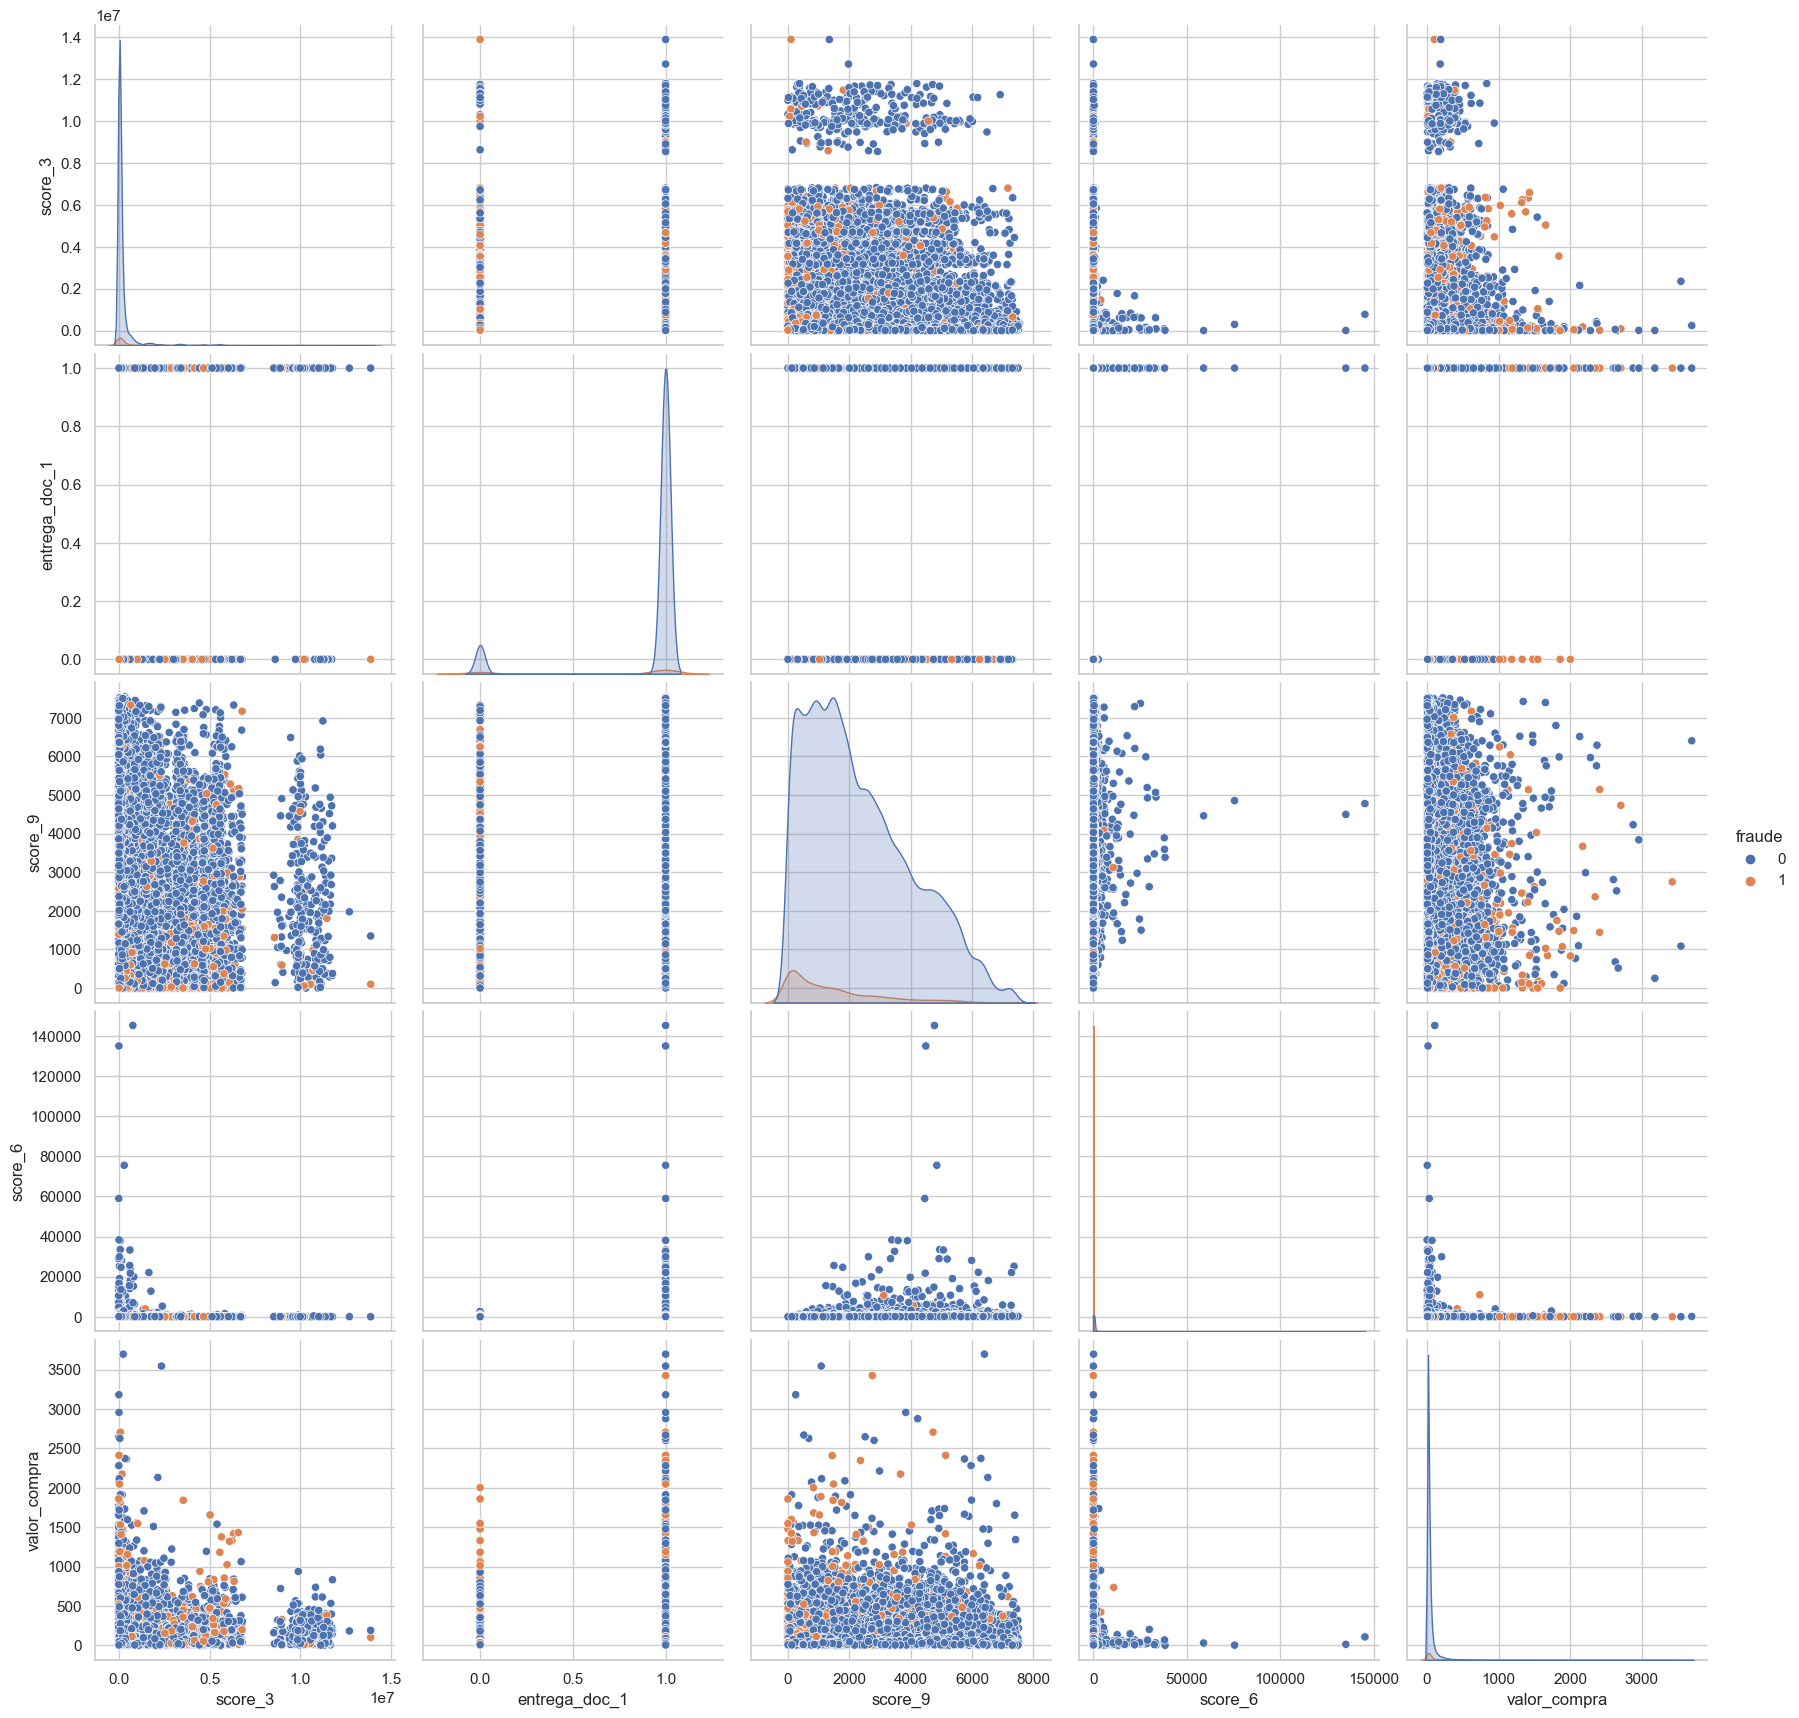

In [37]:
sns.pairplot(base_pairplot, hue = 'fraude', height=3.5)
plt.show()

Não foi possível observar nenhuma relação clara a partir dos gráficos acima

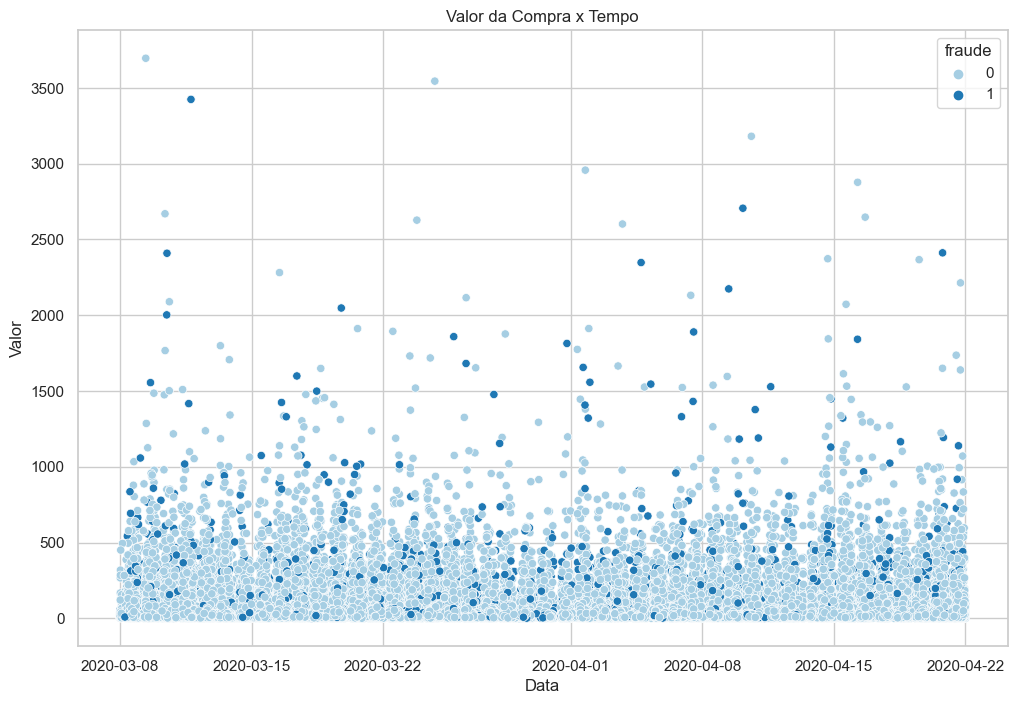

In [38]:
plt.figure(figsize=(12,8))

sns.scatterplot(x = 'data_compra', y = 'valor_compra', 
                hue = 'fraude', data = base, palette='Paired')
plt.title('Valor da Compra x Tempo')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.show()

Não pudemos observar nenhuma relação entre o Valor da compra e o período

In [39]:
#criando uma cópia do dataset
base_copy = base.copy()

In [40]:
#colocando o dia em uma coluna separada para melhor visualização
base_copy['dia'] = base_copy['data_compra'].dt.day

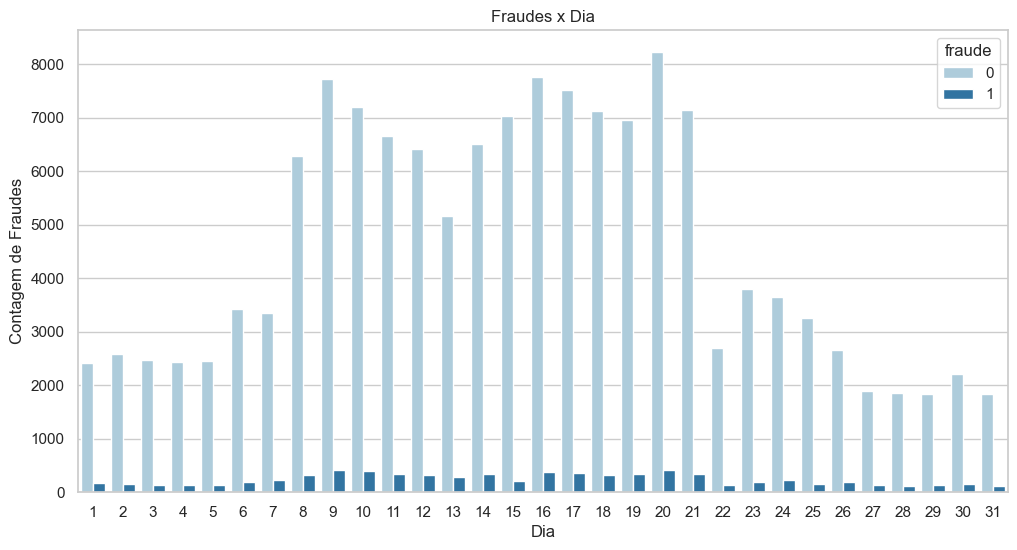

In [41]:
#plotando o gráfico

plt.figure(figsize=(12,6))
sns.countplot(x = 'dia', hue = 'fraude',data = base_copy, palette= 'Paired')

plt.title('Fraudes x Dia')
plt.xlabel('Dia')
plt.ylabel('Contagem de Fraudes')

plt.show()

Parece haver uma relação entre dia e fraude, para confirmar, realizaremos um teste estatístico.

Utilizaremos o teste t de Student para realizar um teste de hipóteses

In [42]:
#utilizando t de Student

test1 = base_copy['dia']
test2 = base_copy['fraude']

t_statistics, p_value = stats.ttest_ind(test1, test2)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


In [43]:
#colocando o mês em uma coluna separada
base_copy['mes'] = base_copy['data_compra'].dt.month

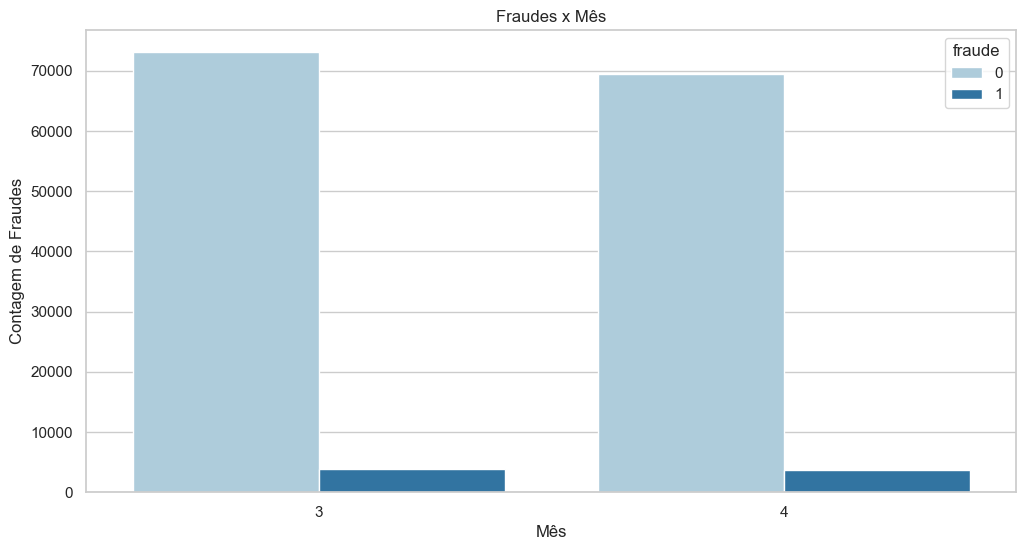

In [44]:
#visualizando graficamente
plt.figure(figsize=(12,6))
sns.countplot(x = 'mes', hue = 'fraude',data = base_copy, palette= 'Paired')

plt.title('Fraudes x Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem de Fraudes')

plt.show()

In [45]:
#utilizando t de Student

test3 = base_copy['mes']
test4 = base_copy['fraude']

t_statistics, p_value = stats.ttest_ind(test3, test4)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


In [46]:
#colocando a hora em uma coluna separada
base_copy['hora'] = base_copy['data_compra'].dt.hour

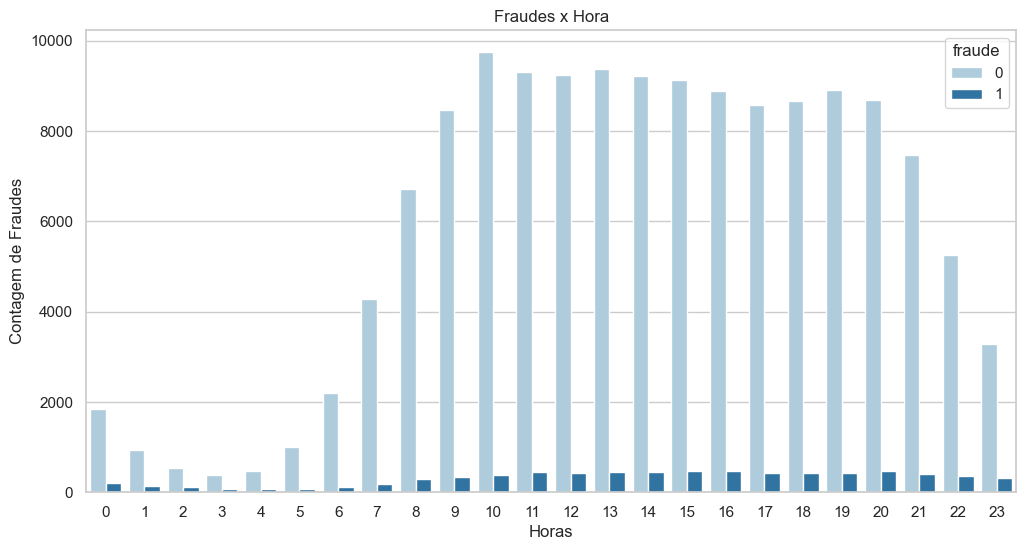

In [47]:
#visualizando graficamente
plt.figure(figsize=(12,6))
sns.countplot(x = 'hora', hue = 'fraude',data = base_copy, palette= 'Paired')

plt.title('Fraudes x Hora')
plt.xlabel('Horas')
plt.ylabel('Contagem de Fraudes')

plt.show()

Parece haver uma relação entre o horário e a fraude mas para confirmar, iremos realizar um teste estatístico.

In [48]:
test_h = base_copy['hora']
test_f = base_copy['fraude']

t_statistics, p_value = stats.ttest_ind(test_h, test_f)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


Testando relação entre 'score_1' e 'fraude'

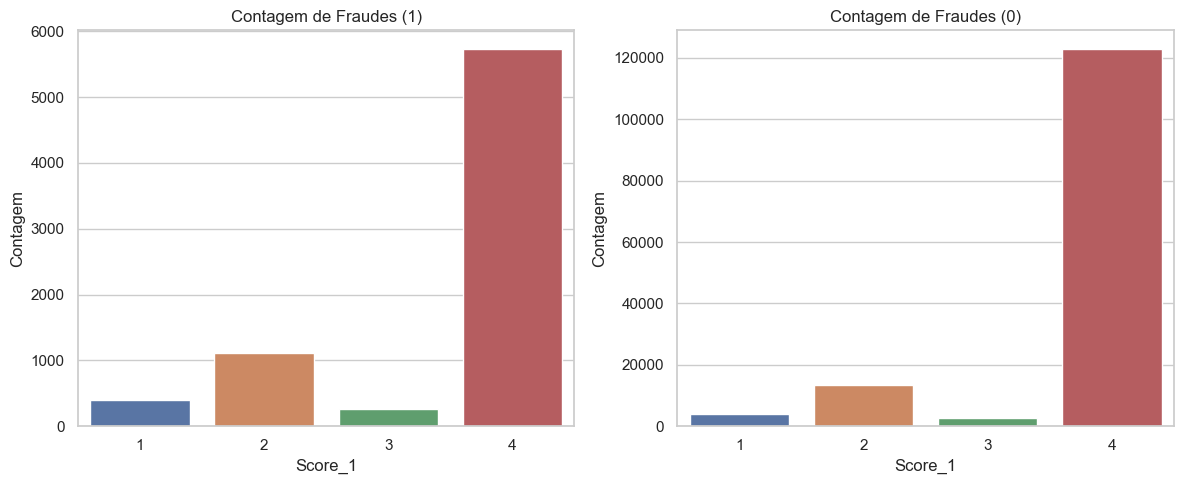

In [49]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

#quando fraude == 1
base_fraude1 = base[base['fraude']== 1]
sns.countplot(x = 'score_1', data = base_fraude1, ax = axes[0])
axes[0].set_title('Contagem de Fraudes (1)')
axes[0].set_xlabel('Score_1')
axes[0].set_ylabel('Contagem')

#quando fraude == 0
base_fraude0 = base[base['fraude']== 0]
sns.countplot(x = 'score_1', data = base_fraude0, ax = axes[1])
axes[1].set_title('Contagem de Fraudes (0)')
axes[1].set_xlabel('Score_1')
axes[1].set_ylabel('Contagem')

plt.tight_layout()
plt.show()

In [50]:
# realizando teste T de Student para verificar se há relação  entre 'score_1' e 'fraude'
testf1 = base['score_1']
testf2 = base['fraude']

t_statistics, p_value = stats.ttest_ind(testf1, testf2)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


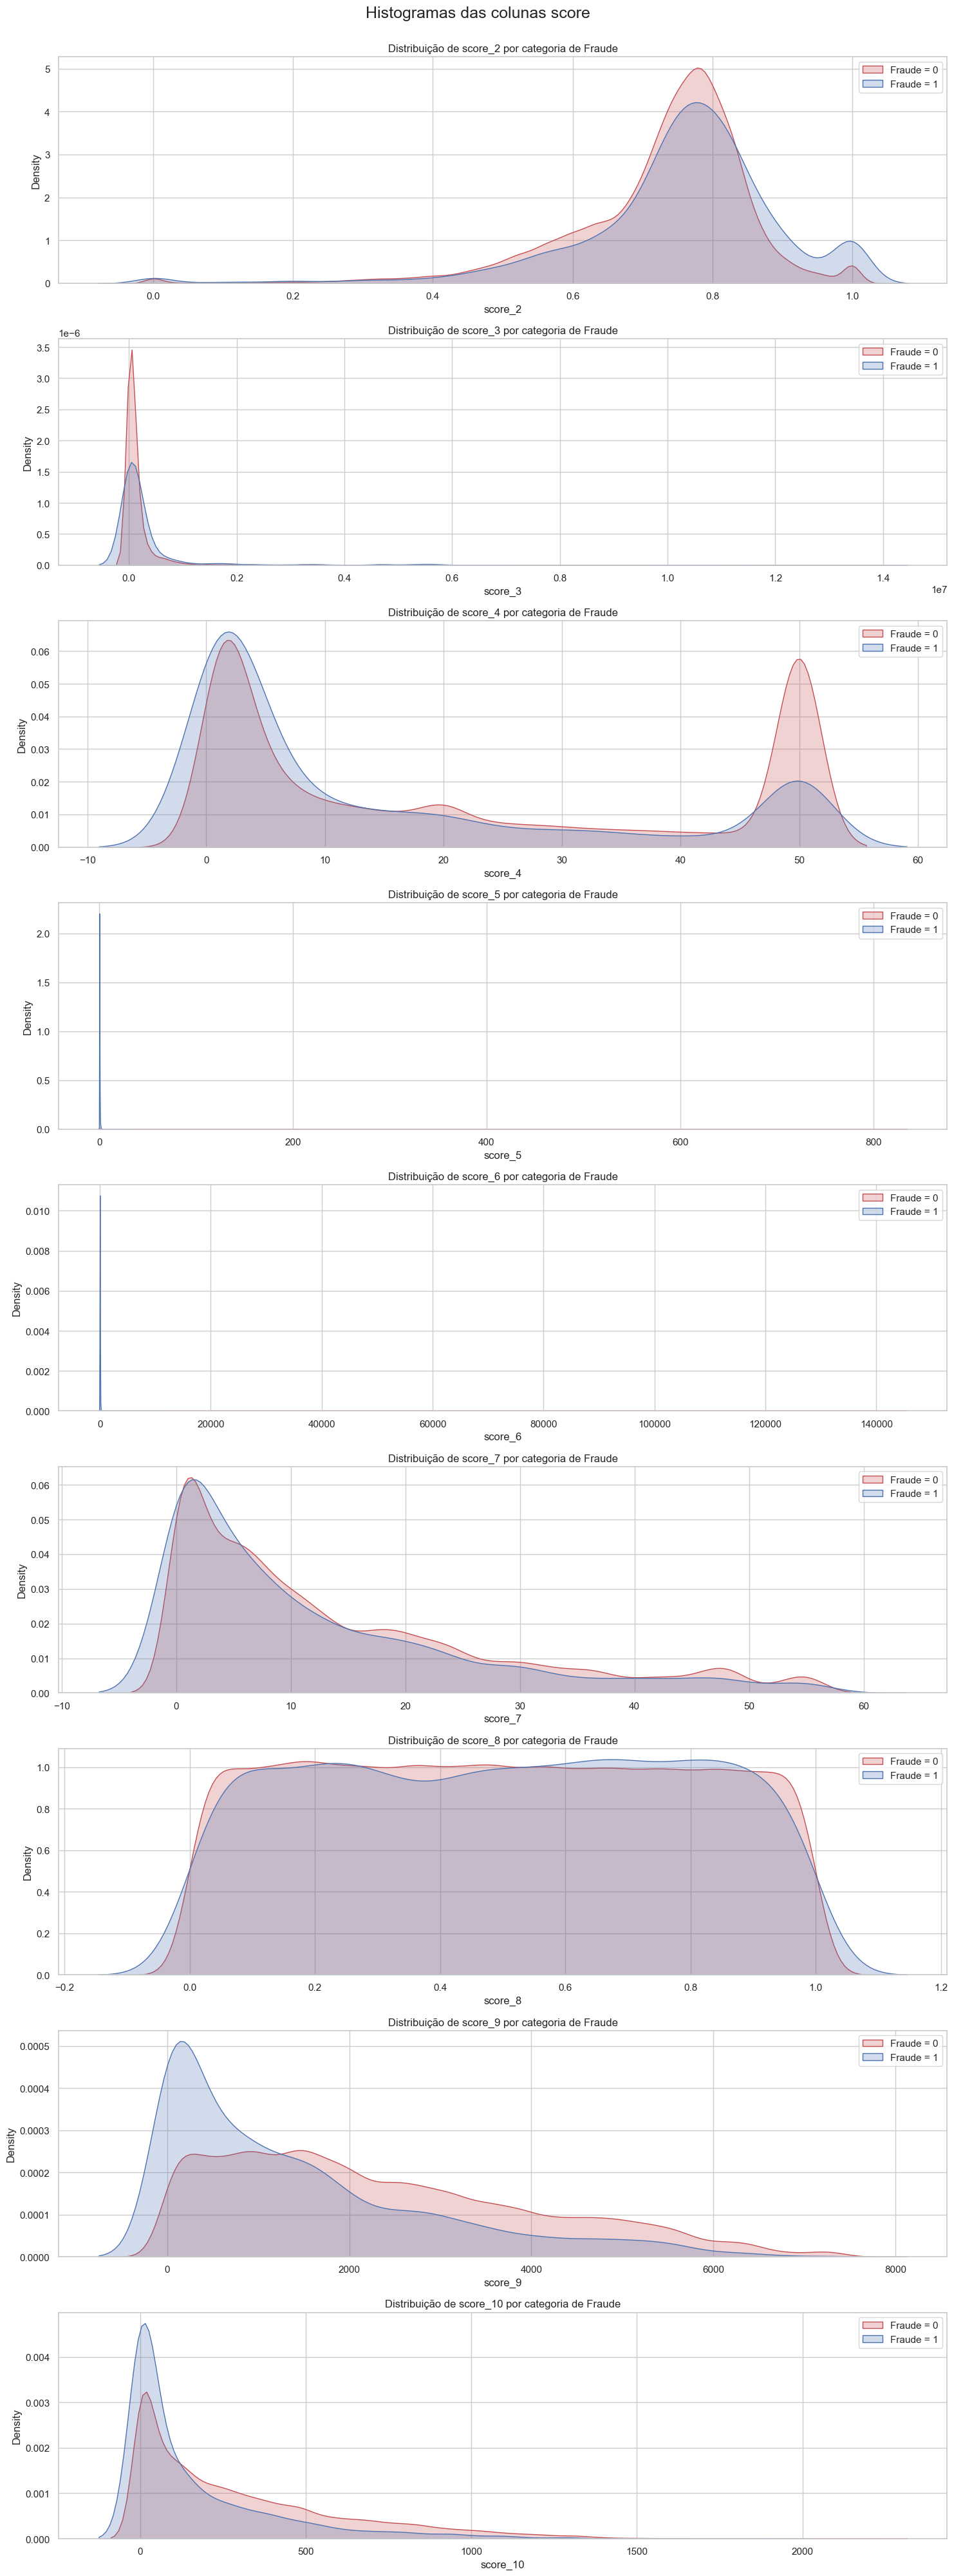

In [51]:
# verificando as fraudes nas categorias 'score'
colunas = ['score_2','score_3','score_4','score_5', 'score_6','score_7',
           'score_8','score_9','score_10']

fig, axarr = plt.subplots(len(colunas), 1, figsize=(15,40))

# criando o gráfico
for i, col in enumerate(colunas):
    sns.kdeplot(base[base['fraude'] == 0][col],ax = axarr[i],
                label = 'Fraude = 0', fill = True, color = 'r')
    sns.kdeplot(base[base['fraude'] == 1][col], ax = axarr[i], 
                label = 'Fraude = 1',fill= True)
    axarr[i].set_title(f'Distribuição de {col} por categoria de Fraude')
    axarr[i].legend()
    

# título geral da figura
plt.suptitle('Histogramas das colunas score', fontsize = 18, y =1)

# ajusta e mostra o gráfico
plt.tight_layout()
plt.show()

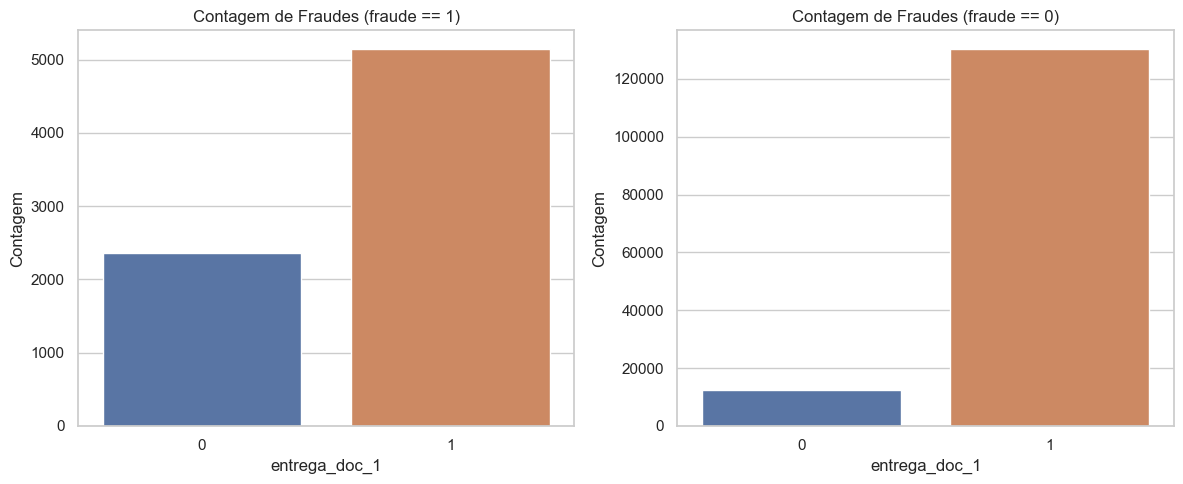

In [52]:
# verificando relação entre a entrega de documentos (doc_1) e a fraude
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
base_fraude_1 = base[base["fraude"] == 1]
sns.countplot(x="entrega_doc_1", data=base_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_1")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
base_fraude_0 = base[base["fraude"] == 0]
sns.countplot(x="entrega_doc_1", data=base_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_1")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()
        

In [53]:
test_doc1 = base['entrega_doc_1']
test_doc_1_2 = base['fraude']

t_statistics, p_value = stats.ttest_ind(test_doc1, test_doc_1_2)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


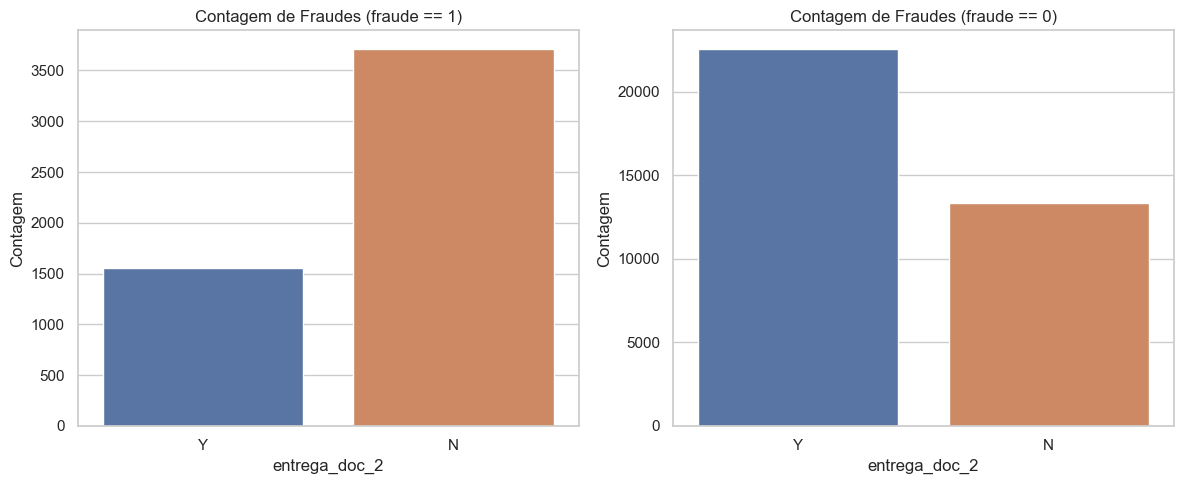

In [54]:
# verificando relação entre a entrega de documentos (doc_2) e a fraude
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
base_fraude_1 = base[base["fraude"] == 1]
sns.countplot(x="entrega_doc_2", data=base_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_2")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
base_fraude_0 = base[base["fraude"] == 0]
sns.countplot(x="entrega_doc_2", data=base_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_2")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()
        

In [55]:
# utilizando qui-quadrado para a coluna 'entrega_doc_2 por conta de termos valores 'float'
contingency_table = pd.crosstab(base["entrega_doc_2"], base["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_2' e 'fraude' parecem ser inependentes.")

Valor de chi2: 2093.9742824255336
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.


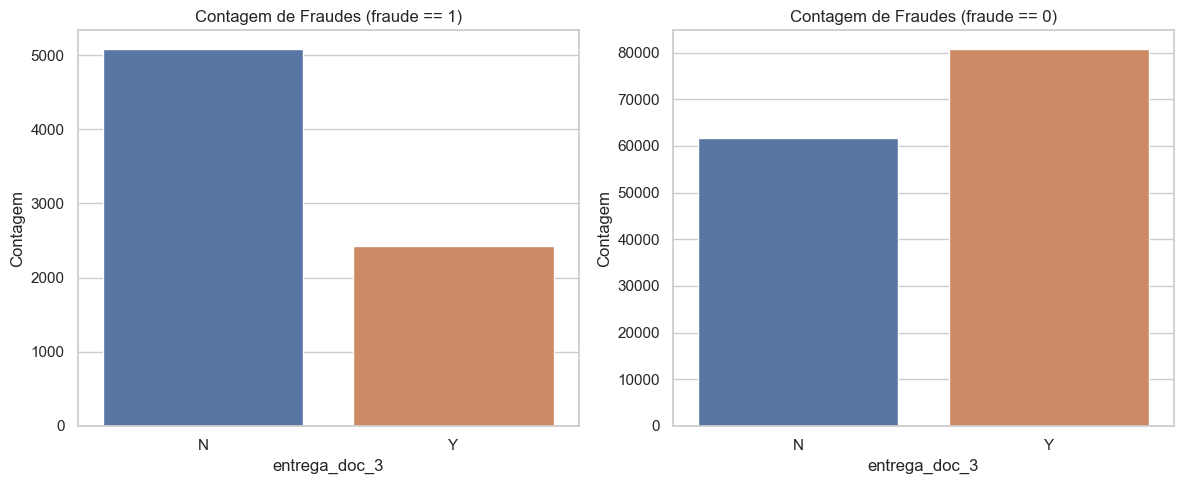

In [56]:
# verificando relação entre a entrega de documentos (doc_3) e a fraude
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
base_fraude_1 = base[base["fraude"] == 1]
sns.countplot(x="entrega_doc_3", data=base_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_3")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
base_fraude_0 = base[base["fraude"] == 0]
sns.countplot(x="entrega_doc_3", data=base_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_3")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()
        

In [57]:
contingency_table = pd.crosstab(base["entrega_doc_3"], base["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_3' e 'fraude' parecem ser inependentes.")

Valor de chi2: 1709.9413003678396
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.


In [58]:
# visualizando a relação entre país e fraude

contingency_table = pd.crosstab(base["pais"], base["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'pais' e 'fraude' parecem ser inependentes.")

Valor de chi2: 435.0414968257157
Valor p: 7.757972296868586e-63
Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.


In [59]:
# visualizando a relação entre valor da compra e fraude

contingency_table = pd.crosstab(base["valor_compra"], base["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'valor_compra' e 'fraude'.")
else:
     print("Não rejeitamos a hipótese nula. 'valor_compra' e 'fraude' parecem ser inependentes.")

Valor de chi2: 26859.998979289183
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'valor_compra' e 'fraude'.


In [60]:
#confirmando com teste T de Student
test_compra = base['valor_compra']
test_fraude = base['fraude']

t_statistics, p_value = stats.ttest_ind(test_compra, test_fraude)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


## Avaliando o modelo antigo e criando um novo modelo

A separação dos dados deve ocorrer antes para que os dados teste não tenham contato com treino e validação

In [61]:
# separando os dados em treino e teste

RANDOM_STATE = 42
base_train, base_test = train_test_split(base, test_size= 0.2,
                                         random_state= RANDOM_STATE)
#separando em X e Y para treino
X_train = base_train.drop('fraude', axis = 1)
y_train = base_train['fraude']

#separando em X e Y para teste
X_test = base_test.drop('fraude', axis = 1)
y_test = base_test['fraude']


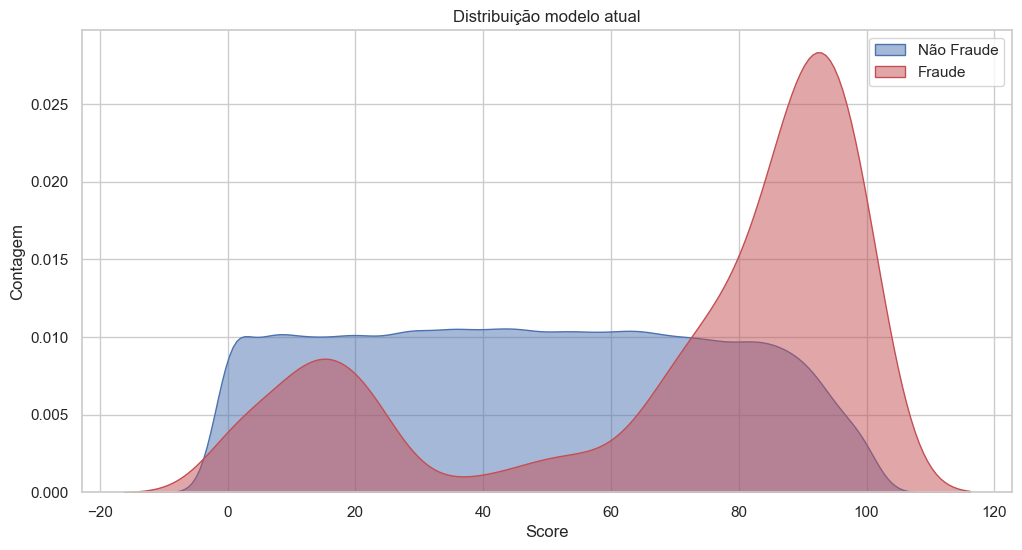

In [62]:
#verificando a distribuição de modelo atual

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.kdeplot(base.loc[lambda base: base.fraude == 0]['score_fraude_modelo'],
            ax=ax, color='b', fill=True, alpha=0.5, label='Não Fraude')
sns.kdeplot(base.loc[lambda base: base.fraude == 1]['score_fraude_modelo'],
            ax=ax, color='r', fill=True, alpha=0.5, label='Fraude')

plt.title('Distribuição modelo atual')
plt.xlabel('Score')
plt.ylabel('Contagem')

ax.legend()

plt.show()

In [63]:
#verificando o modelo a partir de métricas

fpr, tpr, thresholds = roc_curve(base['fraude'], base['score_fraude_modelo'])
roc_auc = auc(fpr, tpr)

print('ROC AUC:', roc_auc)


ROC AUC: 0.726275487251462


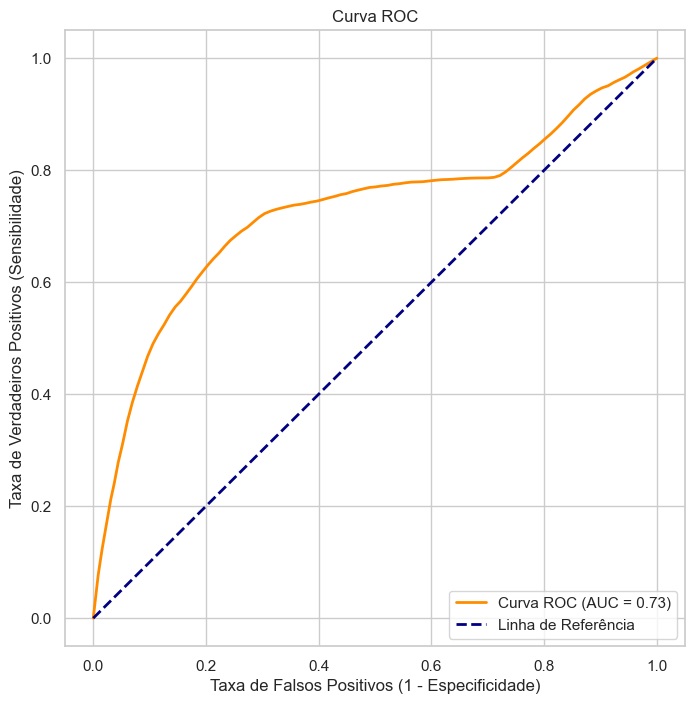

In [64]:
# visualizando a curva ROC 
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [65]:
def profit_from_decision(decision_df, blocked_col, target_col, amount_col):
   
    # Perdas por fraude: não foi bloqueado e era fraude
    decision_base["fraud_losses"] = ((~decision_base[blocked_col]) & (decision_base[target_col])) * decision_base[amount_col]
    
    # Receitas: não bloqueada e não era fraude
    decision_base["revenue"] = ((~decision_base[blocked_col]) & (~decision_base[target_col])) * decision_base[amount_col] * 0.1
    
    # Lucro:diferença entre receitas e perdas por fraude
    decision_base["profit"] = decision_base["revenue"] - decision_base["fraud_losses"]
    
    return decision_base[["fraud_losses", "revenue", "profit"]].sum()

In [66]:
def profit_from_decision(decision_base, blocked_col, target_col, amount_col):
    # Perdas por fraude: não foi bloqueado e era fraude
    decision_base["fraud_losses"] = ((~decision_base[blocked_col]) & (decision_base[target_col])) * decision_base[amount_col]
    
    # Receitas: não bloqueada e não era fraude
    decision_base["revenue"] = ((~decision_base[blocked_col]) & (~decision_base[target_col])) * decision_base[amount_col] * 0.1
    
    # Lucro: diferença entre receitas e perdas por fraude
    decision_base["profit"] = decision_base["revenue"] - decision_base["fraud_losses"]
    
    return decision_base[["fraud_losses", "revenue", "profit"]].sum()

def evaluate_thresholds(base_test, target_col, prediction_col, amount_col, blocked_col, possible_thresholds):
    all_decisions = []

    for threshold in possible_thresholds:
        # Criando uma cópia do DataFrame de teste com a coluna 'blocked' atualizada com base no limiar
        base_test_with_decision = base_test.assign(blocked=lambda df: base_test[prediction_col] >= threshold)

        # Calculando o lucro da decisão com base no limiar
        decision_profit = profit_from_decision(base_test_with_decision, blocked_col, target_col, amount_col)

        # guardando o resultado na lista
        all_decisions.append(decision_profit)

    # concatenando os resultados em um DataFrame
    threshold_evaluation = pd.concat(all_decisions, axis=1, keys=possible_thresholds).T.rename_axis("threshold").reset_index()

    return threshold_evaluation

target_col = "fraude"
prediction_col = "score_fraude_modelo"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)

# avaliando diferentes limiares
threshold_evaluation = evaluate_thresholds(base_test, target_col, prediction_col, amount_col, blocked_col, possible_thresholds)

# usando o display para melhor visualização
display(threshold_evaluation)

threshold  fraud_losses     revenue     profit
0           1       1181.23    3242.109   2060.879
1           2       1890.99    3917.883   2026.893
2           3       1969.12    4829.258   2860.138
3           4       2288.36    5726.876   3438.516
4           5       2692.96    6743.685   4050.725
..        ...           ...         ...        ...
94         95      84125.99  111680.516  27554.526
95         96      87603.24  112932.551  25329.311
96         97      90925.22  113735.367  22810.147
97         98      94238.31  114322.705  20084.395
98         99      97012.02  114967.326  17955.306

[99 rows x 4 columns]

In [67]:
# agora verificando os valores para o melhor limiar
best_threshold = threshold_evaluation.loc[threshold_evaluation['profit'].idxmax()]['threshold']
best_anterior = threshold_evaluation.loc[lambda base: base['profit'].idxmax()]
best_anterior.reset_index().rename(columns = {72: 'Valor ($)'})

index  Valor ($)
0     threshold     73.000
1  fraud_losses  25353.320
2       revenue  80329.995
3        profit  54976.675

Com o modelo atual há uma perda por fraude de mais de 25 mil dólares, uma receita de pouco mais de 80 mil e um lucro próximo de 55 mil.

In [68]:
# criando uma matriz de confusão para melhor visualizar
base_test['predicted'] = base_test[prediction_col] >= best_threshold
conf_matrix = confusion_matrix(base_test[target_col], base_test['predicted'])

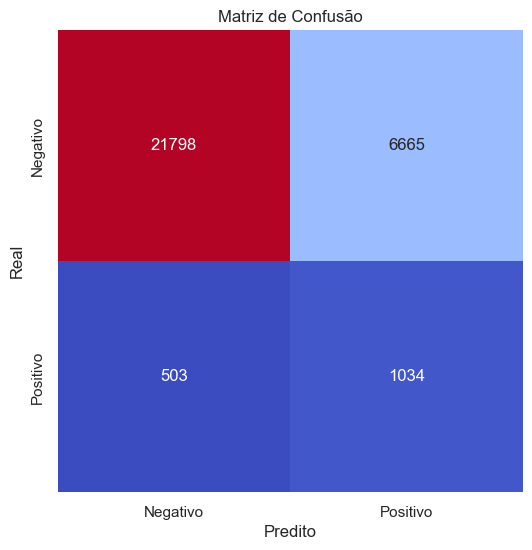

In [69]:
#plotando a matriz
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [70]:
# calculando a taxa de fraude e de aprovação do modelo atual
verdadeiros_positivos = conf_matrix[1, 1]  
falsos_negativos = conf_matrix[1, 0]  
verdadeiros_negativos = conf_matrix[0, 0]  
falsos_positivos = conf_matrix[0, 1] 

# calculando as taxas
fraud_rate = falsos_negativos / (verdadeiros_negativos + falsos_negativos)
approval_rate = verdadeiros_negativos / (verdadeiros_negativos + falsos_positivos)

print(f"Taxa de Fraude: {fraud_rate * 100:.2f}%")
print(f"Taxa de Aprovação: {approval_rate * 100:.2f}%")

Taxa de Fraude: 2.26%
Taxa de Aprovação: 76.58%


In [71]:
# iremos verificar mais métricas para posteriormente compararmos ao novo modelo que será implementado
y_pred_binary = base_test[prediction_col] >= best_threshold

#importando as métricas
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

auc_score = roc_auc_score(y_test, base_test[prediction_col]>= best_threshold)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,y_pred_binary)

print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"F1-Score: {f1:.2f}")

Precisão: 0.13
Recall: 0.67
AUC Score: 0.7193
F1-Score: 0.22


##### Tendo já realizado a análise do modelo atual, agora iremos começar o pré processamento para criarmos um novo modelo.

###### Pré- processamento dos dados

- Exclusão da coluna score_fraude_modelo, pois ela é o resultado do modelo atual

- Retirada da coluna data_compra para que o tempo não tenha efeito sobre o modelo

- na coluna entrega_doc_2 os valores nulos serão considerados como 0, como se não houvesse a entrega do documento



- Valores nulos serão preenchidos com a mediana (não são normais)

- Iremos utilizar apenas os dados provenientes dos dois países que contabilizam 80% das fraudes, Brasil e Argentina (BR e AR)

- criação de feature  para indicar quais os valores nulos de entrega_doc_2

- one hot encoder nas variáveis categóricas

- target encoder em categoria_produto por conta da cardinalidade

In [72]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cols_to_drop = ['data_compra', 'produto', 'score_fraude_modelo', 'categoria_produto']
        X.drop(columns=cols_to_drop, axis=1, inplace=True)
        return X

class DataProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['is_missing'] = X['entrega_doc_2'].isnull().astype(int)
        X['entrega_doc_2'] = X['entrega_doc_2'].fillna('N')
        X['entrega_doc_2'] = X['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)
        X['pais'] = X['pais'].apply(lambda x: x if x in ['BR', 'AR'] else 'Outros')
        X['entrega_doc_3'] = X['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)
        return X

class ScoreImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputers = {}
    
    def fit(self, X, y=None):
        cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']
        for col in cols:
            imputer = SimpleImputer(strategy="median")
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self
    
    def transform(self, X):
        for col, imputer in self.imputers.items():
            X[col] = imputer.transform(X[[col]])
        return X

In [73]:
# tratando com OneHotEncoder
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False)
        self.cols = ['score_1', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'is_missing']
    
    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self
    
    def transform(self, X):
        onehot_data = self.encoder.transform(X[self.cols])
        onehot_base = pd.DataFrame(onehot_data, columns=self.encoder.get_feature_names_out(self.cols))
        onehot_base.index = X.index
        X = X.drop(self.cols, axis=1)
        X = pd.concat([X, onehot_base], axis=1)
        return X

In [74]:
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialization parameters
        self.colnames = 'categoria_produto'
        self.targetName = 'fraude'
        self.n_fold = 5
        self.verbosity = True
        self.discardOriginal_col = False

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        # média da variável alvo
        mean_of_target = X[self.targetName].mean()
        
       
        kf = KFold(n_splits=self.n_fold, shuffle=True, random_state=42)

        # nova coluna KFold
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        # K-fold target encoding
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        # preenchendo valores NaN com a média
        X[col_mean_name].fillna(mean_of_target, inplace=True)

        
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print(f"Encoded Feature Values: {encoded_feature}")

        # retirando a coluna original
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)

        # dataframe modificado
        return X

In [75]:
# criando o pipeline
def pipeline(model):
    # Criando
    pipe = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("onehot", OneHotFeatureEncoder()),
        ('classifier', model)
    ])
    return pipe

In [76]:
# encontrando as categorias que não estão nas 1000 principais
produtos_categorias = category_fraud_info[1000:]
lista_categorias_outros = produtos_categorias['categoria_produto'].to_list()

# substituindo as categorias que não estão nas 1000 principais por "Outros"
base.loc[~base['categoria_produto'].isin(lista_categorias_outros), 'categoria_produto'] = 'Outros'


In [80]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

targetc = KFoldTargetEncoder()
base_train = targetc.fit_transform(base_train)
base_test = targetc.transform(base_test)

# Separating into training and testing
X_train = base_train.drop('fraude', axis=1)
y_train = base_train['fraude']

X_test = base_test.drop('fraude', axis=1)
y_test = base_test['fraude']

# Define the pipeline inside RandomizedSearchCV
model_name = 'BalancedRandomForest'
model = BalancedRandomForestClassifier(random_state=42)

# Include the preprocessing steps in the pipeline
pipe = Pipeline([
    ("dropper", ColumnDropper()),
    ("processor", DataProcessor()),
    ("imputer", ScoreImputer()),
    ("onehot", OneHotFeatureEncoder()),
    ('classifier', model)
])

# Define hyperparameter distributions for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(50, 201),  # Random integers between 50 and 200
    'classifier__max_depth': [None, 10, 20]
}

# Perform RandomizedSearchCV
randomized_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc', random_state=42)

# Fit the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    randomized_search.fit(X_train, y_train)

# Display the results
results_balanced_rf_randomized = pd.DataFrame({
    'Model': model_name,
    'Best ROC AUC': randomized_search.best_score_,
    'Best Parameters': randomized_search.best_params_
}, index=[0])

print(results_balanced_rf_randomized)

Encoded Feature Values: [0.01449275 0.03125    0.01694915 ... 0.         0.01612903 0.03076923]
Encoded Feature Values: [0.         0.05882353 0.06578947 ... 0.         0.05123333 0.05123333]
                  Model  Best ROC AUC  Best Parameters
0  BalancedRandomForest      0.845711              NaN


In [81]:
BRandomForest = BalancedRandomForestClassifier(random_state=42)
XGB = XGBClassifier(scale_pos_weight=19, random_state=42)
LGB = LGBMClassifier(class_weight='balanced', random_state=42)
DecisionTree = DecisionTreeClassifier(class_weight='balanced', random_state=42)


In [ ]:
models = [BRandomForest, LGB, XGB, DecisionTree]

results = []

# KFold para validação cruzada
for model in models:
    pipe = pipeline(model)
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    
    # Extrai o nome do modelo 
    model_name = model.__class__.__name__
    
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(msg)


# desativando as mensagens do LGBM (ou não)
lgbm_params = {

    'force_row_wise': True,
    'disable_default_eval_metric': True,
    'silent': True
}

# Comparação gráfica
fig, ax = plt.subplots(figsize=(10, 6))  
ax.boxplot(results)
ax.set_xticklabels([model.__class__.__name__ for model in models])  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.tight_layout()  
plt.title('Comparação entre os modelos')
plt.show()

##### Acima, utilizamos o KFold Cross Validation no qual o conjunto de dados foi dividido em 5 amostras e através dele pode-se avaliar a performance e a generalização de cada modelo e pudemos observar que a Árvore de Decisão apresentou um resultado ruim em comparação aos outros algoritmos.
##### Já o XGBoost teve desempenho semelhante aos outros porém a Balanced Random Forest e o LightGBM apresentaram desempenho ainda melhor

###### Tanto a Balanced Random Forest quanto o LightGBm tiveram um bom desempenho e resultados semelhantes e ambos poderiam ser utilizados. Decidi utilizar o LightGBM por sua facilidade em ajuste de parâmetros e por ser eficaz mesmo com recursos computacionais limitados. 

##### Já que escolhemos o modelo, agora iremos verificar os melhores hiperparâmetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Balanced Random Forest
model_name = 'BalancedRandomForest'
model = BalancedRandomForestClassifier(random_state=42)

# Create the pipeline for the model
pipe = make_pipeline(ColumnDropper(), DataProcessor(), ScoreImputer(), OneHotFeatureEncoder(), model)

# Define hyperparameter distributions for RandomizedSearchCV
param_dist = {
    'balancedrandomforestclassifier__n_estimators': randint(50, 201),  # Random integers between 50 and 200
    'balancedrandomforestclassifier__max_depth': [None, 10, 20]
}

# Perform RandomizedSearchCV
randomized_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc', random_state=42)

# Fit the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    randomized_search.fit(X_train, y_train)

# Display the results
results_balanced_rf_randomized = pd.DataFrame({
    'Model': model_name,
    'Best ROC AUC': randomized_search.best_score_,
    'Best Parameters': randomized_search.best_params_
}, index=[0])

print(results_balanced_rf_randomized)

In [ ]:
# Balanced Random Forest
model_name = 'BalancedRandomForest'
model = BalancedRandomForestClassifier(random_state=42)

# Create the pipeline for the model
pipe = make_pipeline(ColumnDropper(), DataProcessor(), ScoreImputer(), OneHotFeatureEncoder(), model)

# Define hyperparameters for GridSearchCV (you can customize this)
parameters = {'balancedrandomforestclassifier__n_estimators': [50, 100, 200],
              'balancedrandomforestclassifier__max_depth': [None, 10, 20]}

# Perform GridSearchCV
grid_search = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc')

# Fit the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search.fit(X_train, y_train)

# Display the results
results_balanced_rf = pd.DataFrame({
    'Model': model_name,
    'Best ROC AUC': grid_search.best_score_,
    'Best Parameters': grid_search.best_params_
}, index=[0])

print(results_balanced_rf)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Defina os modelos
models = [
    ('BalancedRandomForest', BalancedRandomForestClassifier(random_state=42)),
    ('LGB', LGBMClassifier(class_weight='balanced', random_state=42, force_row_wise=True, disable_default_eval_metric=True, silent=True)),
    ('XGB', XGBClassifier(scale_pos_weight=19, random_state=42)),
    ('DecisionTree', DecisionTreeClassifier(class_weight='balanced', random_state=42))
]

results = []

# KFold para validação cruzada
for model_name, model in models:
    # Crie o pipeline para o modelo
    pipe = make_pipeline(ColumnDropper(), DataProcessor(), ScoreImputer(), OneHotFeatureEncoder(), model)
    
    # Realize a busca de hiperparâmetros usando GridSearchCV
    parameters = {}
    grid_search = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc')
    
    # Ajuste o modelo
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, y_train)
    
    # Adicione os resultados ao dataframe
    results.append({
        'Model': model_name,
        'Best ROC AUC': grid_search.best_score_,
        'Best Parameters': grid_search.best_params_
    })

# Exiba os resultados em um dataframe
results_base = pd.DataFrame(results)
print(results_base)